In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/RegionalSpanish/notebooks`


In [2]:
using SimilaritySearch, SimSearchManifoldLearning, TextSearch, LinearAlgebra, HDF5, JSON, JLD2, CSV, DataFrames, Glob, StatsBase, Plots

In [3]:
pwd()

"/home/sadit/Research/RegionalSpanish/notebooks"

In [4]:
edir = "../data/SpanishLang/embeddings"
k = 33
common = CSV.read("../data/SpanishLang/common-tokens-per-region.tsv.gz", DataFrame, delim='\t')
subset!(common, :n_regions => n -> n .> 10)
cclist = split(first(subset(common, :n_regions => n -> n .== 26).country_codes), ',')
cclist = [cc for cc in cclist if cc != "GQ"]  # removing GQ since it has too few intersecting tokens
@info sort!(cclist)

┌ Info: SubString{String}["ALL", "AR", "BO", "BR", "CA", "CL", "CO", "CR", "CU", "DO", "EC", "ES", "FR", "GB", "GT", "HN", "MX", "NI", "PA", "PE", "PR", "PY", "SV", "US", "UY", "VE"]
└ @ Main In[4]:7


In [5]:
function encode_model(knns, dists, vocab)
    #vocab = Symbol.(vocab)
    #  ivocab = Dict(token => i for (i, token) in enumerate(vocab))
    obj = Dict{UInt64,Float64}()
    for (i, (idcol, distcol)) in enumerate(zip(eachcol(knns), eachcol(dists)))
        for j in eachindex(idcol, distcol)
            w = (vocab[i], vocab[idcol[j]])
            s = hash(w)
            obj[s] = 1.0 + 1 / (1 + distcol[j])
        end
    end
 
    normalize!(obj)
end

encode_model (generic function with 1 method)

In [6]:
db = []

for cc in cclist
    modelname = only(glob(joinpath(edir, "knns-common-tokens.cc=$cc*.h5")))
    @info modelname
    knns_, dists_, vocab_ = load(modelname, "knns", "dists", "vocab")
    push!(db, encode_model(knns_, dists_, vocab_))
end

length(db)

┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=ALL-1.7m.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=AR.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=BO.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=BR.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CA.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CL.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CO.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CR.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=CU.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=DO.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data/SpanishLang/embeddings/knns-common-tokens.cc=EC.k=33.h5
└ @ Main In[6]:5
┌ Info: ../data

26

In [7]:
dist = NormalizedCosineDistance()
n = length(cclist)
A = Matrix{Float64}(undef, n, n)

for (i, cc) in enumerate(cclist)
    u = db[i]
    A[i, i] = 0.0
    @time for j in i+1:n
        v = db[j]
        A[j, i] = A[i, j] = evaluate(dist, u, v)
    end
end

  2.526757 seconds (29.92 k allocations: 1.529 MiB, 1.30% compilation time)
  2.347415 seconds (49 allocations: 1.156 KiB)
  1.233610 seconds (47 allocations: 1.109 KiB)
  1.576453 seconds (45 allocations: 1.062 KiB)
  1.396961 seconds (43 allocations: 1.016 KiB)
  1.977428 seconds (41 allocations: 992 bytes)
  1.850293 seconds (39 allocations: 944 bytes)
  1.504546 seconds (37 allocations: 896 bytes)
  0.392114 seconds (35 allocations: 848 bytes)
  1.420552 seconds (33 allocations: 800 bytes)
  1.443654 seconds (31 allocations: 752 bytes)
  1.374833 seconds (29 allocations: 704 bytes)
  0.867762 seconds (27 allocations: 656 bytes)
  0.858127 seconds (25 allocations: 608 bytes)
  0.839069 seconds (23 allocations: 560 bytes)
  0.640286 seconds (21 allocations: 512 bytes)
  0.936030 seconds (19 allocations: 464 bytes)
  0.523186 seconds (17 allocations: 416 bytes)
  0.662249 seconds (15 allocations: 368 bytes)
  0.603311 seconds (13 allocations: 320 bytes)
  0.145413 seconds (11 allocati

In [8]:
function creatergb!(C)
    for i in (1, 2, 3)
        v = @view C[i, :]
        # s = 4 * std(v)
        min_, max_ = extrema(v)
        # v .= v ./ s .+ 0.5

        for j in eachindex(v)
            x = (v[j] - min_) / (max_ - min_)
            v[j] = clamp(x,  0, 1)
        end
    end

    [RGB(c...) for c in eachcol(C)]
end

creatergb! (generic function with 1 method)

  0.038808 seconds (187.77 k allocations: 8.988 MiB, 99.57% compilation time)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.116842254
- embedding init: 1.901550131
- embedding opt: 0.002718642

┌ Info: ======= k=2 =====
└ @ Main In[9]:14


  0.000243 seconds (3 allocations: 640 bytes)


*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.0048e-5
- embedding init: 3.12e-7
- embedding opt: 0.001111472

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=3 =====
└ @ Main In[9]:14


  0.000212 seconds (3 allocations: 832 bytes)
  0.000183 seconds (3 allocations: 1.062 KiB)


*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 4.1106e-5
- embedding init: 8.8e-8
- embedding opt: 0.001535307

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=4 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.8146e-5
- embedding init: 1.02e-7
- embedding opt: 0.00119102

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=5 =====
└ @ Main In[9]:14


  0.000184 seconds (3 allocations: 1.219 KiB)
  0.000171 seconds (3 allocations: 1.531 KiB)


*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 3.7989e-5
- embedding init: 1.54e-7
- embedding opt: 0.003394103

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=6 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 4.3772e-5
- embedding init: 8.0e-8
- embedding opt: 0.002710932

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=7 =====
└ @ Main In[9]:14


  0.000191 seconds (3 allocations: 1.688 KiB)
  0.000191 seconds (3 allocations: 1.844 KiB)


*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 4.9014e-5
- embedding init: 7.9e-8
- embedding opt: 0.003917049

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=8 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding


  0.000231 seconds (5 allocations: 2.406 KiB)


UMAP construction time cost report:
- fuzzy graph: 4.9236e-5
- embedding init: 9.0e-8
- embedding opt: 0.004063958

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=9 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.2651e-5
- embedding init: 1.05e-7
- embedding opt: 0.00593594

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=10 =====
└ @ Main In[9]:14


  0.000070 seconds (3 allocations: 2.375 KiB)
  0.000195 seconds (3 allocations: 2.531 KiB)


*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.6148e-5
- embedding init: 7.8e-8
- embedding opt: 0.004605745

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=11 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.3354e-5
- embedding init: 1.67e-7
- embedding opt: 0.007089277

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=12 =====
└ @ Main In[9]:14


  0.000181 seconds (3 allocations: 2.750 KiB)
  0.000186 seconds (3 allocations: 3.000 KiB)


*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.3199e-5
- embedding init: 1.57e-7
- embedding opt: 0.005289375

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=13 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.4533e-5
- embedding init: 8.0e-8
- embedding opt: 0.009759158

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=14 =====
└ @ Main In[9]:14


  0.000194 seconds (3 allocations: 3.281 KiB)
  0.000202 seconds (3 allocations: 3.281 KiB)


*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.1768e-5
- embedding init: 7.7e-8
- embedding opt: 0.009124349

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=15 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 5.967e-5
- embedding init: 8.8e-8
- embedding opt: 0.007882434



  0.000212 seconds (3 allocations: 3.625 KiB)
  0.000175 seconds (3 allocations: 4.062 KiB)


┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=16 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 8.1027e-5
- embedding init: 8.3e-8
- embedding opt: 0.006753625

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=17 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 6.5744e-5
- embedding init: 8.3e-8
- embedding opt: 0.008399997



  0.000219 seconds (3 allocations: 4.062 KiB)
  0.000203 seconds (3 allocations: 4.062 KiB)


┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=18 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 7.4361e-5
- embedding init: 1.0e-7
- embedding opt: 0.011071945

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=19 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding


  0.000191 seconds (3 allocations: 4.469 KiB)


UMAP construction time cost report:
- fuzzy graph: 6.4074e-5
- embedding init: 8.0e-8
- embedding opt: 0.012664981

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: ======= k=20 =====
└ @ Main In[9]:14
*** computing graph
*** layout embedding PrecomputedLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 6.4994e-5
- embedding init: 8.4e-8
- embedding opt: 0.012615058

┌ Info: (:r, :g, :b)
└ @ Main In[9]:40
┌ Info: Saved animation to /home/sadit/Research/RegionalSpanish/notebooks/tmp.gif
└ @ Plots /home/sadit/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/home/sadit/Research/RegionalSpanish/notebooks/tmp.gif")
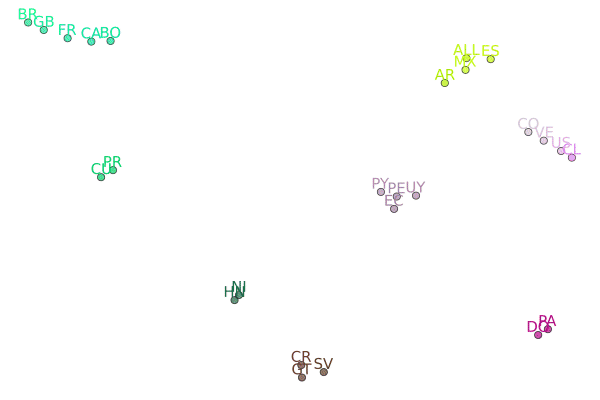

In [9]:
min_dist = 0.2
k = 10
neg_sample_rate = 5
local_connectivity = 1
n_epochs = 100
tol = 1e-4

U3 = fit(UMAP, PrecomputedAffinityMatrix(A); maxoutdim=3, layout=SpectralLayout(), k=4,
            local_connectivity, neg_sample_rate, min_dist, n_epochs, tol)

a = Animation()

for k in 2:20
    @info "======= k=$k ====="
    U3 = fit(UMAP, PrecomputedAffinityMatrix(A); maxoutdim=3,
            layout=PrecomputedLayout(predict(U3)),
            k, local_connectivity, neg_sample_rate, min_dist, n_epochs, tol)

    U2 = fit(U3, 2)

    X = predict(U2)
    C = creatergb!(predict(U3))
    #C .= C .+ 5

    #poslist = rand([:right, :left, :bottom, :top], length(cclist))
    poslist = rand([:bottom], length(cclist))

    scatter(X[1, :], X[2, :], c=C, label="",
        series_annotations=[text(cclist[i], poslist[i], 10, C[i]) for i in eachindex(cclist)],
        xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
        ms=4, ma=0.7, fa=0.7,
        la=0.7,
        alpha=0.7
    )
    #scatter!(X[1, :], X[2, :], c=C, label="",
    #    series_annotations=[text(cclist[i], poslist[i], 10, C[i]) for i in eachindex(cclist)], xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
    #    ms=5, ma=0.5, fa=0.5, la=0.5, alpha=0.5)
    savefig("../figs/fig-voc-semantic-umap-$k.pdf")
    savefig("../figs/fig-voc-semantic-umap-$k.png")
    @info fieldnames(typeof(C[1]))
    open(joinpath(edir, "colormap-common-voc-semantic-$k.csv"), "w") do f
        println(f, "country,R,G,B")
        for (i, (cc, c)) in enumerate(zip(cclist, C))
            println(f, cc, ",", c.r, ",", c.g, ",", c.b)
        end
    end
    
    frame(a, plot!(fmt=:png)) #|> display
end

gif(a, fps=1)

In [10]:
#=D = Dict(zip(cclist, db))
@show [
evaluate(dist, D["MX"], D["MX"])
evaluate(dist, D["MX"], D["ALL"])
evaluate(dist, D["MX"], D["SV"])
evaluate(dist, D["ES"], D["GQ"])
]

@info D["MX"][:iglesia]
@info D["US"][:iglesia]
=#

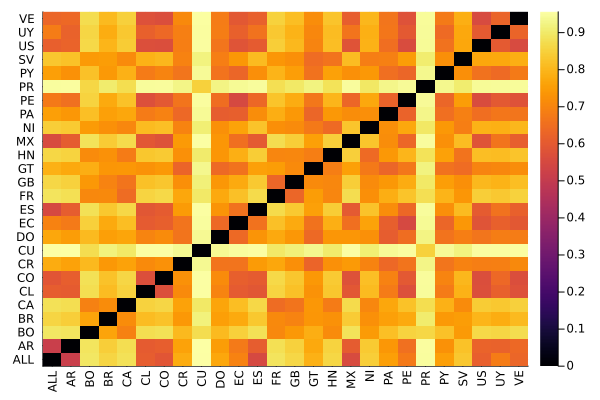

In [11]:
heatmap(cclist, cclist, A, ticks = :all, xrot=90)
savefig("../figs/fig-common-words-semantic-affinity-matrix.pdf")
savefig("../figs/fig-common-words-semantic-affinity-matrix.png")
plot!(fmt=:png)